In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from sklearn.datasets import load_diabetes
from imblearn.over_sampling import SMOTE, RandomOverSampler

/Users/Walter/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
GOAL = ['target']
FEATURES = ['age','sex','bmi','bp',
            's1','s2','s3',
            's4','s5','s6']
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = [] # features that require pre-processing

over_sampling = False

In [3]:
def run_load_data():
    print ('load_data - START')
    diabetes = load_diabetes()
    data = pd.DataFrame(data= np.c_[diabetes['data'], \
                                     diabetes['target']],
                        columns= ['age','sex','bmi','bp',
                                  's1','s2','s3',
                                  's4','s5','s6',
                                  'target'] 
                        )
    
    print ('load_data - END')
    return data

In [4]:
def run_train_test_split(data):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [5]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # Fill NULL with Mean / Median / -1
    for f in FEATURES:
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        train_df[f] = imp.fit_transform(train_df[f].reshape(-1,1))
        test_df[f] = imp.fit_transform(test_df[f].reshape(-1,1))
    
    # Pre-processing non-numeric values using numeric encoding
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    # Encode using .cat.codes or LabelEncoder:
    # http://pbpython.com/categorical-encoding.html
    for f in CATEGORICAL_FEATURES:
        train_df[f] = train_df[f].astype('category').cat.codes
        test_df[f] = test_df[f].astype('category').cat.codes
#         lbl = LabelEncoder()
#         train_df[f] = lbl.fit_transform(train_df[f].reshape(-1,1))
#         test_df[f] = lbl.fit_transform(test_df[f].reshape(-1,1))
    print ('pre_processing - END') 
    return train_df, test_df

In [6]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [7]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [8]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4],
        'n_estimators': [500, 750],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }
    gbm = xgb.XGBRegressor()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='neg_mean_squared_error', cv=5, verbose=1)
    grid.fit(X_train, y_train)

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best Negative Mean Squared Error found: ", grid.best_score_)

    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_sub_sample = grid.best_params_["subsample"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"] 
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree

In [9]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"reg:linear", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "subsample":best_sub_sample,
              "colsample_bytree":best_colsample_bytree
             }
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        num_boost_round=10,
                        metrics="rmse",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-rmse-mean"].iloc[-1]
    print "cross-validation model rmse on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')    

In [10]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('train_model - START')    
    model = xgb.XGBRegressor(objective='reg:linear',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              subsample=best_sub_sample,
                              colsample_bytree=best_colsample_bytree,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [11]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [12]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    average_percentage_error = round(np.mean(((prediction/y_test)-1)*100),2)
    print "model average_percentage_error on test dataset: ", average_percentage_error,"%"    
    model_evaluation_metric = round(mean_squared_error(y_test, prediction),2)
    print "model mean_squared_error on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END') 

In [13]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START


/Users/Walter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/Walter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/Walter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/Users/Walter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 4})
('Best Negative Mean Squared Error found: ', -3811.4036918187385)
grid_search - END
cross_validation - START
   test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0      164.384299      10.187975       164.458282        2.443081
1      157.809921       9.857982       157.469962        2.398373
2      151.353976       9.603073       150.788834        2.314822
3      145.114871       9.511469       144.466348        2.209035
4      139.162643       9.203579       138.525415        2.215444
5      133.726495       9.177691       132.711615        2.068306
6      128.490726       9.122058       127.168826        1.951379
7      123.598462       9.054778       122.117691        1.897011
8      119.015178       8.852606       117.270610        1.797649
9      114.665622       8.554437       112.672565        1.809011
cross-validation model rmse on

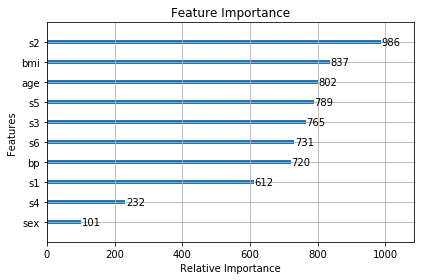

feature_importance - END
('elapsed_time (in seconds): ', 85.80162811279297)


In [14]:
def xgboost_regression():
    start_time = time.time()
    data = run_load_data()
    train_df, test_df = run_train_test_split(data) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree = run_grid_search(X_train, y_train)
    run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_feature_importance(model)
    print('elapsed_time (in seconds): ', time.time() - start_time)
xgboost_regression()